In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
import numpy as np
tf.reset_default_graph()

random_seed = 42
from numpy.random import seed
seed(random_seed)
from tensorflow import set_random_seed
set_random_seed(random_seed)
import random
random.seed(random_seed)
#print(random.getstate())

from keras import backend as K

with tf.device('/gpu:0'):
    c = tf.random_uniform([], -10, 10)
    d = tf.random_uniform([], -10, 10)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(c))
    print(sess.run(d))
    
    
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)   
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)    

K.set_session(sess)    
#print(sess)
#config = tf.ConfigProto(
#        device_count = {'GPU': 0}
#    )
#sess = tf.Session(config=config)
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend
# https://stackoverflow.com/questions/46836857/results-not-reproducible-with-keras-and-tensorflow-in-python

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.7579927
3.7836285


In [2]:
import os
import sys
import warnings

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam

import keras
print(keras.__version__)

2.1.3


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'
DATA_PATH = 'data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(train_ids))
print(len(test_ids))

670
65


In [5]:
current_dir = os.getcwd()
print(current_dir)

/home/chen/workspace/git_examples/kaggle-nuclei-challenge


In [6]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def fit_model():
    model = get_model_bn_do()
    model.fit_generator(batches, batches.N, nb_epoch=1, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.N)
    model.optimizer.lr=0.1
    model.fit_generator(batches, batches.N, nb_epoch=4, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.N)
    model.optimizer.lr=0.01
    model.fit_generator(batches, batches.N, nb_epoch=12, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.N)
    model.optimizer.lr=0.001
    model.fit_generator(batches, batches.N, nb_epoch=18, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.N)
    return model

In [7]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

filenames = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    filenames.append(path + '/images/' + id_ + '.png')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

save_array(DATA_PATH + 'X_train.bc', X_train)
save_array(DATA_PATH + 'Y_train.bc', Y_train)
save_array(DATA_PATH + 'X_test.bc', X_test)
save_array(DATA_PATH + 'filenames.bc', filenames)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:50<00:00, 13.24it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 140.34it/s]

Done!


In [8]:
X_train = load_array(DATA_PATH + 'X_train.bc')
Y_train = load_array(DATA_PATH + 'Y_train.bc')
X_test = load_array(DATA_PATH + 'X_test.bc')
filenames = load_array(DATA_PATH + 'filenames.bc')

In [9]:
import PIL
import collections
sizes = [PIL.Image.open(f).size for f in filenames]
collections.Counter(sizes)

Counter({(256, 256): 334,
         (320, 256): 112,
         (347, 260): 5,
         (360, 360): 91,
         (640, 512): 13,
         (696, 520): 92,
         (1024, 1024): 16,
         (1272, 603): 6,
         (1388, 1040): 1})

/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


102


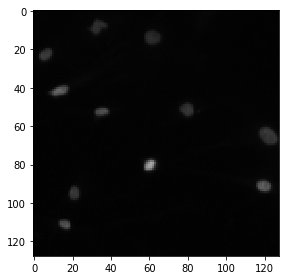

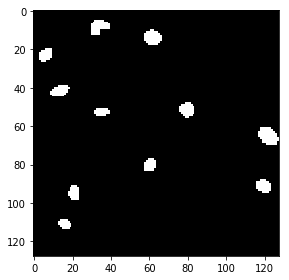

In [10]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
print(ix)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

In [13]:
#earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tmp-v3.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, verbose=1, callbacks=[checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
584/603 [============================>.] - ETA: 0s - loss: 0.5708 - mean_iou: 0.4157
Epoch 00001: val_loss improved from inf to 0.44784, saving model to model-tmp-v3.h5
603/603 [==============================] - 3s 5ms/step - loss: 0.5661 - mean_iou: 0.4160 - val_loss: 0.4478 - val_mean_iou: 0.4246
Epoch 2/100
584/603 [============================>.] - ETA: 0s - loss: 0.3559 - mean_iou: 0.4247
Epoch 00002: val_loss improved from 0.44784 to 0.27703, saving model to model-tmp-v3.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.3542 - mean_iou: 0.4247 - val_loss: 0.2770 - val_mean_iou: 0.4251
Epoch 3/100
584/603 [============================>.] - ETA: 0s - loss: 0.2245 - mean_iou: 0.4418
Epoch 00003: val_loss improved from 0.27703 to 0.20388, saving model to model-tmp-v3.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.2220 - mean_iou: 0.4426 - val_loss: 0.2039 - val_mean_iou: 0.4712
Epoch 4/100

Epoch 29/100
584/603 [============================>.] - ETA: 0s - loss: 0.0689 - mean_iou: 0.7858
Epoch 00029: val_loss did not improve
603/603 [==============================] - 2s 3ms/step - loss: 0.0687 - mean_iou: 0.7859 - val_loss: 0.0916 - val_mean_iou: 0.7872
Epoch 30/100
584/603 [============================>.] - ETA: 0s - loss: 0.0678 - mean_iou: 0.7885
Epoch 00030: val_loss did not improve
603/603 [==============================] - 2s 3ms/step - loss: 0.0679 - mean_iou: 0.7886 - val_loss: 0.0901 - val_mean_iou: 0.7898
Epoch 31/100
584/603 [============================>.] - ETA: 0s - loss: 0.0682 - mean_iou: 0.7909
Epoch 00031: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0677 - mean_iou: 0.7910 - val_loss: 0.0922 - val_mean_iou: 0.7922
Epoch 32/100
584/603 [============================>.] - ETA: 0s - loss: 0.0671 - mean_iou: 0.7933
Epoch 00032: val_loss improved from 0.08803 to 0.08684, saving model to model-tmp-v3.h5
603/603 [====

584/603 [============================>.] - ETA: 0s - loss: 0.0524 - mean_iou: 0.8323
Epoch 00059: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0518 - mean_iou: 0.8323 - val_loss: 0.0904 - val_mean_iou: 0.8329
Epoch 60/100
584/603 [============================>.] - ETA: 0s - loss: 0.0510 - mean_iou: 0.8334
Epoch 00060: val_loss did not improve
603/603 [==============================] - 2s 3ms/step - loss: 0.0506 - mean_iou: 0.8334 - val_loss: 0.0911 - val_mean_iou: 0.8339
Epoch 61/100
584/603 [============================>.] - ETA: 0s - loss: 0.0515 - mean_iou: 0.8343
Epoch 00061: val_loss did not improve
603/603 [==============================] - 2s 3ms/step - loss: 0.0514 - mean_iou: 0.8344 - val_loss: 0.0968 - val_mean_iou: 0.8349
Epoch 62/100
584/603 [============================>.] - ETA: 0s - loss: 0.0515 - mean_iou: 0.8353
Epoch 00062: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0511 - mean

Epoch 90/100
584/603 [============================>.] - ETA: 0s - loss: 0.0338 - mean_iou: 0.8590
Epoch 00090: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0335 - mean_iou: 0.8590 - val_loss: 0.1117 - val_mean_iou: 0.8594
Epoch 91/100
584/603 [============================>.] - ETA: 0s - loss: 0.0340 - mean_iou: 0.8597
Epoch 00091: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0338 - mean_iou: 0.8597 - val_loss: 0.1114 - val_mean_iou: 0.8601
Epoch 92/100
584/603 [============================>.] - ETA: 0s - loss: 0.0325 - mean_iou: 0.8604
Epoch 00092: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0328 - mean_iou: 0.8604 - val_loss: 0.1126 - val_mean_iou: 0.8608
Epoch 93/100
584/603 [============================>.] - ETA: 0s - loss: 0.0321 - mean_iou: 0.8611
Epoch 00093: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 

In [14]:
K.set_value(model.optimizer.lr, 0.001)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, verbose=0, callbacks=[checkpointer])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=1, verbose=1, callbacks=[checkpointer])


Epoch 00001: val_loss did not improve

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not improve

Epoch 00021: val_loss did not improve

Epoch 00022: val_loss did not improve

Epoch 00023: val_loss did not improve

Epoch 00024: val_loss did not improve

Epoch 00025: val_loss did not improve

Epoch 00026: val_loss di

In [15]:
K.set_value(model.optimizer.lr, 0.0001)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, verbose=0, callbacks=[checkpointer])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=1, verbose=1, callbacks=[checkpointer])


Epoch 00001: val_loss did not improve

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not improve

Epoch 00021: val_loss did not improve

Epoch 00022: val_loss did not improve

Epoch 00023: val_loss did not improve

Epoch 00024: val_loss did not improve

Epoch 00025: val_loss did not improve

Epoch 00026: val_loss di

In [16]:
K.set_value(model.optimizer.lr, 0.00001)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, verbose=0, callbacks=[checkpointer])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=1, verbose=1, callbacks=[checkpointer])


Epoch 00001: val_loss did not improve

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not improve

Epoch 00021: val_loss did not improve

Epoch 00022: val_loss did not improve

Epoch 00023: val_loss did not improve

Epoch 00024: val_loss did not improve

Epoch 00025: val_loss did not improve

Epoch 00026: val_loss di

In [17]:
# Predict on train, val and test
model = load_model('model-tmp-v3.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 620us/step


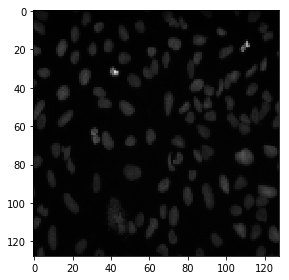

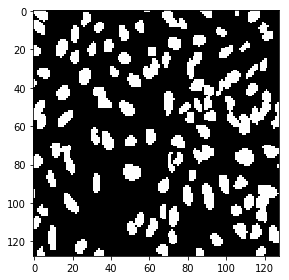

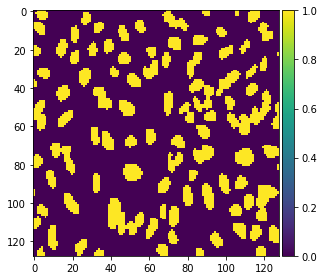

In [18]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

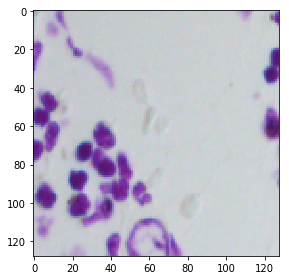

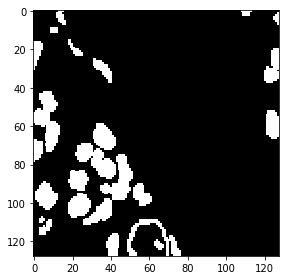

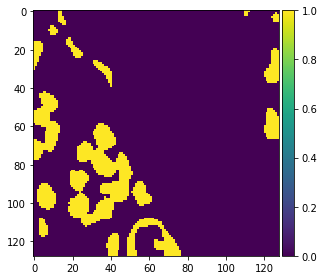

In [19]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [20]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [21]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [22]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-tmp-v3.csv', index=False)